# A machine learning approach for the classification of cardiac arrhythmia
The aim of this project is to determine the type of arrhythmia from the ECG recordings.

Eleonora Detić, 1191241491

### Data collection

Type of research:

- by purpose: **applied** - application in medicine for the early detection of cardiac arrhythmia

- by depth: **correlational** - we study how independent variable("diagnosis") is affected by several distinct dependent variables("age", "sex"..)

- by data type: **quantitative** - we have mathematical, measurable and comparable data

- by variable manipulation: **observational** - researchers observe patients

- by conclusion: **inductive** - we want to generalize things based on sample of pacients

- by time: **synchronous** - we assume that all data are collected at the same time

- by source of information: **secondary** - the researchers read informations about patients from medical documents

- according to the method of data collection: **mixed** - a combination of data known about patients through medical records and ECG data measured under controlled conditions

Data collection method - **documentary** - **limited access**: the main source of data are the patient's medical records.

Data were collected **according to the rules of research ethics** - the names and id numbers of the patients were removed from the database for the privacy purpose.


### Data survey

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from scipy import stats
from pca import pca
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import sklearn.model_selection as model_selection
from sklearn.metrics import f1_score

In [216]:
df = pd.read_csv('data_arrhythmia.csv', delimiter=';')
df.dataframeName = 'data_arrhythmia.csv'
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [217]:
print(df.columns.values)

['age' 'sex' 'height' 'weight' 'qrs_duration' 'p-r_interval'
 'q-t_interval' 't_interval' 'p_interval' 'qrs' 'T' 'P' 'QRST' 'J'
 'heart_rate' 'q_wave' 'r_wave' 's_wave' "R'_wave" "S'_wave" 'AA' 'AB'
 'AC' 'AD' 'AE' 'AF' 'AG' 'AH' 'AI' 'AJ' 'AK' 'AL' 'AM' 'AN' 'AO' 'AP'
 'AR' 'AS' 'AT' 'AU' 'AV' 'AY' 'AZ' "AB'" 'BB' 'BC' 'BD' 'BE' 'BF' 'BG'
 'BH' 'BI' 'BJ' 'BK' 'BL' 'BM' 'BN' 'BO' 'BP' 'BR' 'BS' 'BT' 'BU' 'BV'
 'BY' 'BZ' 'CA' 'CB' 'CC' 'CD' 'CE' 'Cf' 'CG' 'CH' 'CI' 'CJ' 'CK' 'CL'
 'CM' 'CN' 'CO' 'CP' 'CR' 'CS' 'CT' 'CU' 'CV' 'CY' 'CZ' 'DA' 'DB' 'DC'
 'DD' 'DE' 'DF' 'DG' 'DH' 'DI' 'DJ' 'DK' 'DL' 'DM' 'DN' 'DO' 'DP' 'DR'
 'DS' 'DT' 'DU' 'DV' 'DY' 'DZ' 'EA' 'EB' 'EC' 'ED' 'EF' 'EG' 'EH' 'EI'
 'EJ' 'EK' 'EL' 'EM' 'EN' 'EO' 'EP' 'ER' 'ES' 'ET' 'EU' 'EV' 'EY' 'EZ'
 'FA' 'FB' 'FC' 'FD' 'FE' 'FF' 'FG' 'FH' 'FI' 'FJ' 'FK' 'FL' 'FM' 'FN'
 'FO' 'FP' 'FR' 'FS' 'FT' 'FU' 'FV' 'FY' 'FZ' 'GA' 'GB' 'GC' 'GD' 'GE'
 'GF' 'GG' 'GH' 'GI' 'GJ' 'GK' 'GL' 'GM' 'GN' 'GO' 'GP' 'GR' 'GS' 'GT'
 'GU' 'GV' 'GY' 'GZ

In [218]:
df.describe()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.425000,6.600000,-2.100000,0.000000,0.0,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,0.000000,8.800000,-1.100000,0.000000,0.0,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,11.200000,0.000000,0.000000,0.0,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,0.000000,23.600000,0.000000,0.800000,0.0,2.400000,6.000000,88.800000,115.900000,16.000000


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to diagnosis
dtypes: float64(116), int64(159), object(5)
memory usage: 988.9+ KB


In [220]:
print(df.nunique().nlargest(10))
print(df.nunique().nsmallest(19))

KJ    384
JZ    377
JY    354
JM    350
KU    348
KI    336
LG    332
GY    326
HI    318
IP    317
dtype: int64
S'_wave    1
CB         1
CD         1
CS         1
EV         1
EY         1
FF         1
FH         1
FJ         1
FL         1
FS         1
FZ         1
GA         1
GH         1
IB         1
KP         1
LC         1
sex        2
AB         2
dtype: int64


In our data set, we have 452 patients and 279 features for each patient. Some variables are categorical(sex) and some continuous(age). <br> We do not have monotone data, but we have constants data.
Last column is interpreted as a number of heart arrhythmia claster. According to documentation, missing attribute values are distinguished with '?' so the first step is to replace them with "NaN". After that, we will remove the variables that are constant because they tell us nothing about pacients.

In [221]:
df[df == '?'].count().nlargest(10)

J               376
P                22
T                 8
QRST              1
heart_rate        1
age               0
sex               0
height            0
weight            0
qrs_duration      0
dtype: int64

<AxesSubplot:title={'center':'Frequency of NaN values'}>

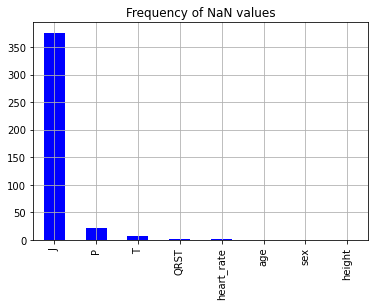

In [222]:
df = df.replace('?', np.NaN)
df.isna().sum().nlargest(8).plot(kind="bar", title="Frequency of NaN values", color='blue', grid='bool')

As we can see, in column 'J' we have a lof of missing values, more than 80%, so we will drop that column.

In [223]:
df.drop(['J'], axis=1, inplace=True)

As for the other columns, since these variables are continuous, the first idea could be to hope for a normal distribution and then try to preserve the variability of the data by randomly simulate the missing values. <br> For this purpose, we perform well know **Kolmogorov–Smirnov** test.

In [78]:
print(stats.kstest(df[df['P'].notnull()]['P'].astype(int), 'norm'))
print(stats.kstest(df[df['T'].notnull()]['T'].astype(int), 'norm'))
print(stats.kstest(df[df['QRST'].notnull()]['QRST'].astype(int), 'norm'))
print(stats.kstest(df[df['heart_rate'].notnull()]['heart_rate'].astype(int), 'norm'))

KstestResult(statistic=0.9255811086972653, pvalue=0.0)
KstestResult(statistic=0.847749201067469, pvalue=0.0)
KstestResult(statistic=0.8168319201501881, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


This assumption was obviously too ambitious. For all columns, the p value turned out to be very small and the test statistics very large. <br> So our conclusion is that at each standard level of significance, we reject the null hypothesis, that is, that our data **do not follow** a normal distribution. <br>
The next idea is standard. We will replace the missing values with the mean of each column.

In [224]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean') # we could also put here '?' as an argument instead of np.nan, but we replace them above
idf = pd.DataFrame(imp.fit_transform(df))
idf.columns = df.columns
idf.index = df.index
df = idf
df.isna().sum().nlargest(10)

age             0
sex             0
height          0
weight          0
qrs_duration    0
p-r_interval    0
q-t_interval    0
t_interval      0
p_interval      0
qrs             0
dtype: int64

Finally, there are no more missing values in our data. <br>
As said before, very important step is to drop variables that will no help our model because they have value that is same for each row.

<AxesSubplot:title={'center':'Number of unique values per column'}>

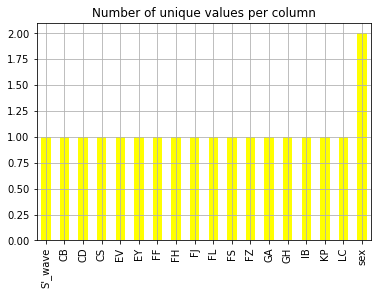

In [225]:
df.nunique().nsmallest(18).plot(kind="bar", title="Number of unique values per column", color='yellow', grid='bool')

In [226]:
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

In [227]:
df.describe()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KV,KY,KZ,LA,LB,LD,LE,LF,LG,diagnosis
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.302434,-0.278982,9.048009,-1.457301,0.003982,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.603551,0.548876,3.472862,2.002430,0.050118,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-5.600000,-4.100000,0.000000,-28.600000,0.000000,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.500000,-0.425000,6.600000,-2.100000,0.000000,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,-0.200000,0.000000,8.800000,-1.100000,0.000000,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,0.000000,11.200000,0.000000,0.000000,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,2.700000,0.000000,23.600000,0.000000,0.800000,2.400000,6.000000,88.800000,115.900000,16.000000


Obviously, there are definitely outliers in the ‘height’ column. It is impossible for a patient to weigh more than 500 kg.

In [228]:
df['height'].nlargest(5)

141    780.0
316    608.0
0      190.0
4      190.0
448    190.0
Name: height, dtype: float64

In [229]:
df = df[df.height < 500]

In [230]:
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KV,KY,KZ,LA,LB,LD,LE,LF,LG,diagnosis
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,-0.3,0.0,9.0,-0.9,0.0,0.9,2.9,23.3,49.4,8.0
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,-0.5,0.0,8.5,0.0,0.0,0.2,2.1,20.4,38.8,6.0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.9,0.0,9.5,-2.4,0.0,0.3,3.4,12.3,49.0,10.0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.1,0.0,12.2,-2.2,0.0,0.4,2.6,34.6,61.6,1.0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,-0.4,0.0,13.1,-3.6,0.0,-0.1,3.9,25.4,62.8,7.0


For more detecting, we use the statistical approach. <br> Modeled on the example of the three-sigma rule, we will try to detect all of those who are "too" far from the mean value.

Total number of coloumns containing possible outliers 1


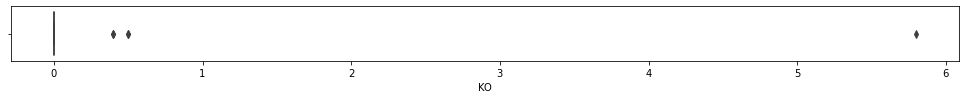

In [231]:
df1=df.select_dtypes(exclude=['object'])
i = 0 

for column in df1:
        if(df[column].max()  > df[column].mean() + 20 * df[column].std() and df[column].nunique() != 2):
                i= i+1 
                plt.figure(figsize=(17,1))
                sns.boxplot(data=df1, x=column)
                
print("Total number of coloumns containing possible outliers", i)

In [232]:
df = df[df.KO < 1 ]

Last but not least, detecting parse data. 

In [238]:
df.astype(bool).sum(axis=0).nsmallest(80)

AB    1
AL    1
AP    1
BC    1
BE    1
     ..
DF    7
AN    8
BF    8
CE    8
DY    8
Length: 80, dtype: int64

As we can see, by removing that outlier, column "CI" became constant, so we will remove it too. 

In [237]:
df.drop(['CI'], axis=1, inplace=True)

Unfortunately, a big problem arises here because we have a lot of parse data. It is generally known that the algorithms we want to develop will behave badly with such data. We will focus to those that have up to eight different values from zero and turn them into dummy variables.

In [244]:
categorical_cols = list(df.astype(bool).sum(axis=0).nsmallest(80).index)
df = pd.get_dummies(df, columns=categorical_cols)

In [247]:
df

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,DF_0.0,DF_1.0,AN_0.0,AN_1.0,BF_0.0,BF_1.0,CE_0.0,CE_1.0,DY_0.0,DY_1.0
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,1,0,1,0,1,0,1,0,1,0
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,1,0,1,0,1,0,1,0,1,0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,1,0,1,0,1,0,1,0,1,0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,1,0,1,0,1,0,1,0,1,0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53.0,1.0,160.0,70.0,80.0,199.0,382.0,154.0,117.0,-37.0,...,1,0,1,0,1,0,1,0,1,0
448,37.0,0.0,190.0,85.0,100.0,137.0,361.0,201.0,73.0,86.0,...,1,0,1,0,1,0,1,0,1,0
449,36.0,0.0,166.0,68.0,108.0,176.0,365.0,194.0,116.0,-85.0,...,1,0,1,0,1,0,1,0,1,0
450,32.0,1.0,155.0,55.0,93.0,106.0,386.0,218.0,63.0,54.0,...,1,0,1,0,1,0,1,0,1,0


In [250]:
df.iloc[:, df.columns != 'diagnosis'].values

array([[ 75.,   0., 190., ...,   0.,   1.,   0.],
       [ 56.,   1., 165., ...,   0.,   1.,   0.],
       [ 54.,   0., 172., ...,   0.,   1.,   0.],
       ...,
       [ 36.,   0., 166., ...,   0.,   1.,   0.],
       [ 32.,   1., 155., ...,   0.,   1.,   0.],
       [ 78.,   1., 160., ...,   0.,   1.,   0.]])

## Principal Component Analysis

Before using PCA, the first step is to scale the features in our data. 

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [374] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [107] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[107]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


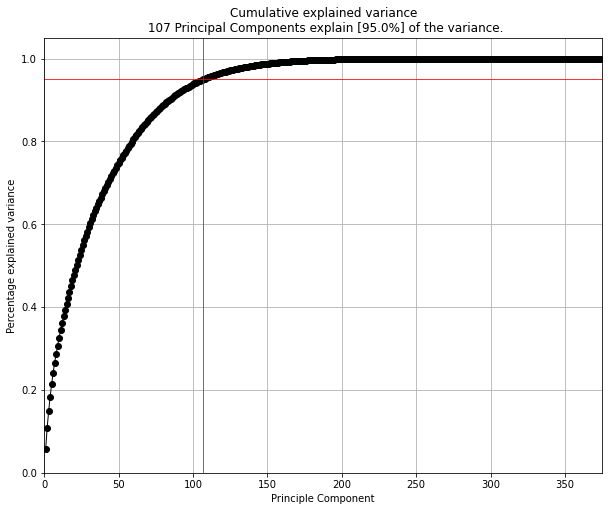

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 107 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [309]:
from pca import pca

X = df.iloc[:, df.columns != 'diagnosis'].values
y = df.iloc[:, df.columns == 'diagnosis'].values
X = StandardScaler().fit_transform(X)

model = pca()
out = model.fit_transform(X)
model.plot()

As we can see, 107 Principal Components explain 95% of the variance and 150 Principal Components explain about 99% of the variance. 

In [310]:
model.compute_topfeat()

,PC,feature,loading,type
0,PC1,128,-0.185687,best
1,PC2,137,-0.179298,best
2,PC3,154,-0.171596,best
3,PC4,5,0.171551,best
4,PC5,238,-0.197667,best
...,...,...,...,...
516,PC298,366,0.198653,weak
517,PC346,368,-0.241214,weak
518,PC22,369,-0.211718,weak
519,PC22,370,0.211718,weak


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'107 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (5.78% expl.var)', ylabel='PC2 (5.11% expl.var)'>)

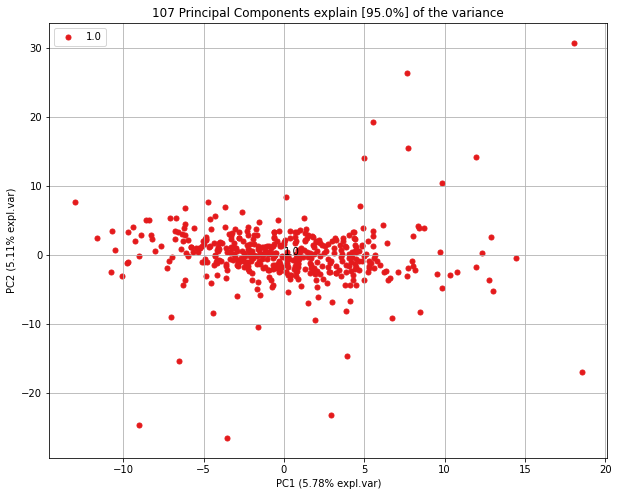

In [258]:
model.scatter()

#### Detection of outliers using PCA

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'107 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (5.78% expl.var)', ylabel='PC2 (5.11% expl.var)'>)

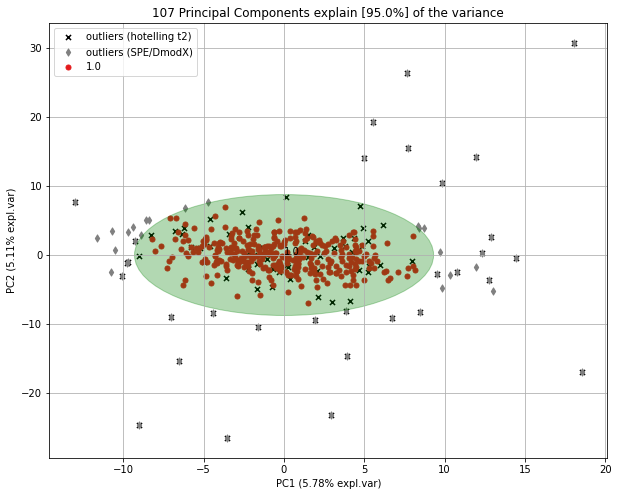

In [259]:
model.scatter(legend=True, SPE=True, hotellingt2=True)

In [260]:
Xoutliers = X[out['outliers']['y_bool'],:]
X_no_outliers = X[~out['outliers']['y_bool'],:]
y_no_outliers = y[~out['outliers']['y_bool'],:]

In [261]:
pd.DataFrame(X_no_outliers)

,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
0,1.756772,-1.105790,2.511796,0.715665,0.148260,0.841247,0.104072,0.114803,1.199277,-1.089766,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
1,0.580951,0.904331,0.110185,-0.276488,-0.518761,0.418243,1.038017,-0.589771,-1.975056,-0.183523,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
2,0.519065,-1.105790,1.070829,1.583798,0.748579,1.041617,0.384255,0.255718,2.050927,-0.117213,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
3,1.756772,-1.105790,2.511796,0.715665,-0.051846,0.574087,-0.238374,0.199352,0.502472,-1.089766,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
4,-2.080120,-1.105790,0.494443,-1.082612,0.748579,0.262400,-1.452502,0.114803,0.037935,1.628964,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-1.646922,0.904331,-0.658330,-0.710555,-0.518761,-0.093813,-0.144980,-0.110660,-0.387890,0.214340,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
361,0.395294,0.904331,-0.370137,0.095569,-0.585463,0.974827,0.446518,-0.448856,1.044431,-1.553940,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
362,-0.594871,-1.105790,2.511796,1.025712,0.748579,-0.405500,-0.207243,0.875743,-0.658869,1.164790,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687
363,-0.904298,0.904331,-0.850459,-0.834574,0.281664,-1.095664,0.571044,1.354853,-1.045983,0.457478,...,0.125846,-0.125846,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687,0.134687,-0.134687


For reduction of the dimension of our data set, we decide to take first 150 PCA components.

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [374] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[150]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


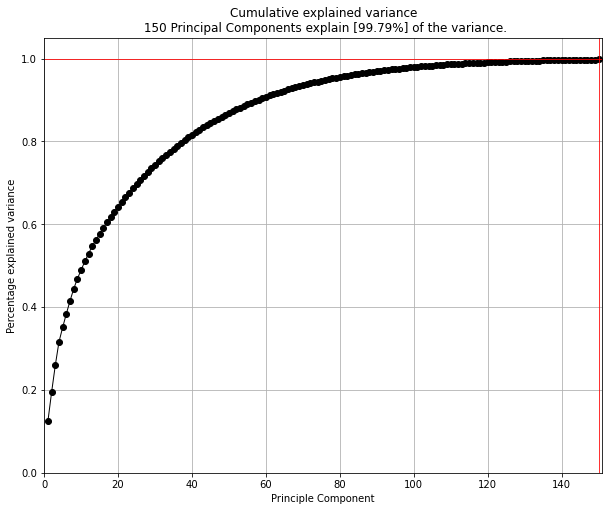

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 150 Principal Components explain [99.79%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [311]:
model = pca(n_components=150)
out = model.fit_transform(X_no_outliers)
model.plot()

In [312]:
X_after_pca = np.array(model.transform(X_no_outliers))

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.


In [313]:
pd.DataFrame(X_after_pca)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,2.009957,1.990525,1.075731,0.075122,-2.781412,1.921562,0.495797,4.782392,-3.301438,-0.496748,...,0.052803,0.035933,-0.069490,0.167054,-0.045234,0.125099,0.031179,0.016264,-0.064113,-0.094042
1,0.136766,1.192730,-1.873917,-3.773326,0.637696,-0.275670,3.878094,-0.707155,1.099060,-0.735999,...,-0.109102,-0.255576,0.058630,-0.123904,-0.357620,-0.132392,-0.176395,0.126685,0.039013,-0.065326
2,-0.081710,3.962115,-2.622701,-0.112235,0.810502,-2.532656,-0.101669,2.379122,-3.615758,1.455319,...,0.262839,0.204974,-0.006974,-0.274013,0.066421,0.195654,-0.081704,0.272617,0.056779,0.049041
3,2.797226,0.672205,-0.757622,0.981564,-2.376065,1.504798,2.030401,3.734562,-5.004934,-0.954916,...,-0.064369,0.313074,-0.055369,0.062025,-0.066009,0.127861,0.074998,-0.280667,0.038598,-0.125139
4,-11.736076,-6.900235,1.670601,8.246648,-2.100135,-6.414930,0.786877,4.806296,5.302441,6.037215,...,0.034639,0.072953,0.136883,0.029245,0.228141,0.022035,0.011364,0.317493,0.136129,0.047125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-1.967658,2.596949,-2.685344,1.253800,-0.967658,0.958636,-0.904228,-1.665267,-0.794873,-0.275425,...,0.300880,0.209933,-0.076699,-0.040859,-0.039405,-0.039664,0.152039,-0.072748,-0.147504,0.123861
361,9.108034,-1.992911,-1.505482,0.380540,-0.426474,0.110798,-0.566550,0.766760,0.243769,1.122565,...,0.012013,0.068452,-0.261743,0.092389,0.013240,-0.011280,-0.034537,0.000155,-0.051253,0.258577
362,-8.125351,0.710524,-3.718055,2.997037,2.506108,-0.895612,-1.565281,2.069416,-4.298326,-5.485029,...,-0.207905,-0.168955,0.168729,-0.129614,0.184815,-0.215506,0.005655,-0.012343,0.069007,0.249414
363,-4.059077,3.415005,-1.774001,-1.256399,0.508163,-1.461822,3.905224,1.998738,1.954914,-0.500759,...,0.214376,0.178605,0.106750,0.058003,-0.121643,0.024525,0.149477,-0.193817,0.266035,-0.077018


### Classification 

In [266]:
X = X_after_pca
y = y_no_outliers

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.70, test_size=0.30,)

#### Support Vector Machine

In [295]:
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  64.55
F1 (Polynomial Kernel):  53.13


/Users/eleonoradetic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### Logistic Regression Algorithm

In [296]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)
lm_accuracy = accuracy_score(y_test, lm.predict(X_test))
print('Accuracy (Logistric Regression): ', "%.2f" % (lm_accuracy * 100))

Accuracy (Logistric Regression):  62.73


/Users/eleonoradetic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### K-Nearest Neighbors Algorithm

In [376]:
number_neig = [n for n in range(1, 20)]

accuracy_scores1 = []

for nt in number_neig:
    knn = KNeighborsClassifier(nt)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test) 
    accuracy_scores1.append(accuracy_score(y_test, y_pred))

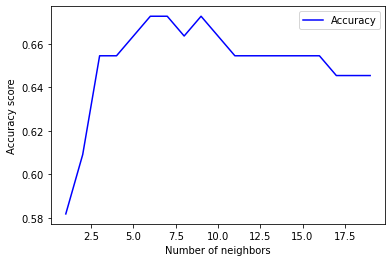

In [377]:
fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(number_neig, accuracy_scores1, label="Accuracy", color="blue")

ax.set_ylabel("Accuracy score")
ax.set_xlabel("Number of neighbors")
ax.legend()

In [378]:
knn = KNeighborsClassifier(6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test) 

print('Accuracy (K-Nearest Neighbors): ', "%.2f" % (accuracy_score(y_test, y_pred) *100))

Accuracy (K-Nearest Neighbors):  67.27


#### Random Forest Algorithm

In [379]:
number_trees = [n for n in range(1, 30)]

accuracy_scores2 = []

for nt in number_trees:
    ranf = RandomForestClassifier(n_estimators = nt, criterion = 'entropy', random_state = 42)
    ranf.fit(X_train, y_train)
    y_pred = ranf.predict(X_test) 
    accuracy_scores2.append(accuracy_score(y_test, y_pred))

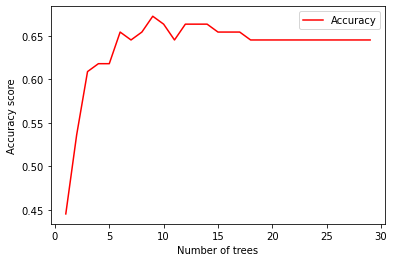

In [380]:
fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(number_trees, accuracy_scores2, label="Accuracy", color="red")

ax.set_ylabel("Accuracy score")
ax.set_xlabel("Number of trees")
ax.legend()

In [372]:
ranf = RandomForestClassifier(n_estimators = 9, criterion = 'entropy', random_state = 42)
ranf.fit(X_train, y_train)
ypred = ranf.predict(X_test) 
ranf_accuracy = accuracy_score(y_test,ypred)
print('Accuracy (Random Forest): ', "%.2f" % (ranf_accuracy *100))

Accuracy (Random Forest):  67.27
